In [11]:
# 导入工具包
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import find_events, Epochs, compute_covariance, make_ad_hoc_cov
from mne.datasets import sample
from mne.simulation import (simulate_sparse_stc, simulate_raw,
                            add_noise, add_ecg, add_eog)

In [12]:
# data_path如果不修改，默认会到网络上面去下载数据集的
#data_path = sample.data_path()

data_path = "E:/MNE-sample-data"
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'

# 加载真实数据作为模板
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference(projection=True)

Opening raw data file E:/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Adding average EEG reference projection.
1 projection items deactivated


<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~3.6 MB, data not loaded>

Reading forward solution from E:/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    MEG and EEG forward solutions combined
    Source spaces transformed to the forward solution coordinate frame


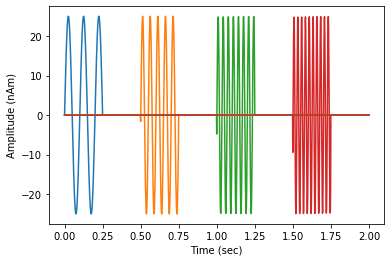

In [13]:
#生成偶极子时间序列


# 设置偶极子的数量
n_dipoles = 4
# 每个epoch或者event的时间窗口长度
epoch_duration = 2.
#谐波数
n = 0
# 随机状态（可复制）
rng = np.random.RandomState(0)

def data_fun(times):
    """产生时间交错的正弦波，谐波为10Hz"""
    global n
    n_samp = len(times)
    window = np.zeros(n_samp)
    start, stop = [int(ii * float(n_samp) / (2 * n_dipoles))
                   for ii in (2 * n, 2 * n + 1)]
    window[start:stop] = 1.
    n += 1
    data = 25e-9 * np.sin(2. * np.pi * 10. * n * times)
    data *= window
    return data


times = raw.times[:int(raw.info['sfreq'] * epoch_duration)]
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']
stc = simulate_sparse_stc(src, n_dipoles=n_dipoles, times=times,
                          data_fun=data_fun, random_state=rng)
# look at our source data
fig, ax = plt.subplots(1)
ax.plot(times, 1e9 * stc.data.T)
ax.set(ylabel='Amplitude (nAm)', xlabel='Time (sec)')
mne.viz.utils.plt_show()



Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
Setting up forward solutions
Computing gain matrix for transform #1/1
    Simulating data for forward operator 1/0
    Interval 0.000-2.000 sec
    Interval 2.000-3.999 sec
    Interval 3.999-5.999 sec
    Interval 5.999-7.998 sec
    Interval 7.998-9.998 sec
    Interval 9.998-11.998 sec
    Interval 11.998-13.997 sec
    Interval 13.997-15.997 sec
    Interval 15.997-17.997 sec
    Interval 17.997-19.996 sec
    10 STC iterations provided
Done
Adding noise to 366/376 channels (366 channels in cov)
Sphere                : origin at (0.0 0.0 0.0) mm
              radius  : 90.0 mm
Source location file  : dict()
Assuming input in millimeters
Assuming input in MRI coordinates

Positions (in meters) and orientations
1 sources
ecg simulated and trace not stored
Setting up forward solutions
Computing gain matrix for transform #1/1
Sphere                : origin at (0.0 0.0 0

LinAlgError: SVD did not converge

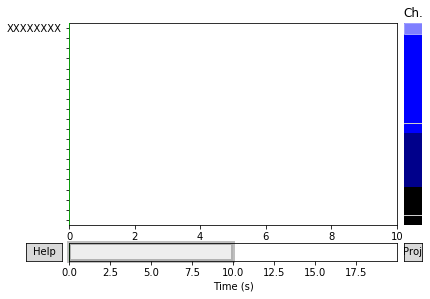

In [14]:
"""
模拟原始数据
"""
raw_sim = simulate_raw(raw.info, [stc] * 10, forward=fwd,verbose=True)
cov = make_ad_hoc_cov(raw_sim.info)
add_noise(raw_sim, cov, iir_filter=[0.2, -0.2, 0.04], random_state=rng)
add_ecg(raw_sim, random_state=rng)
add_eog(raw_sim, random_state=rng)
raw_sim.plot()
plt.show()

In [15]:
"""
绘制诱发数据
"""
events = find_events(raw_sim)  # only 1 pos, so event number == 1
epochs = Epochs(raw_sim, events, 1, tmin=-0.2, tmax=epoch_duration)
cov = compute_covariance(epochs, tmax=0., method='empirical',
                         verbose='error')  # quick calc
evoked = epochs.average()
evoked.plot_white(cov, time_unit='s')
plt.show()


Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
9 events found
Event IDs: [1]
9 matching events found
Applying baseline correction (mode: mean)
Not setting metadata


LinAlgError: SVD did not converge